In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/multilabel_quotation.csv')

In [9]:
df.head()

,Unnamed: 0,Quote,Category
0,0,"Don't cry because it's over, smile because it ...",life
1,1,"Don't cry because it's over, smile because it ...",happiness
2,2,"I'm selfish, impatient and a little insecure. ...",love
3,3,"I'm selfish, impatient and a little insecure. ...",life
4,4,"I'm selfish, impatient and a little insecure. ...",truth


In [10]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
df.head()

,Quote,Category
0,"Don't cry because it's over, smile because it ...",life
1,"Don't cry because it's over, smile because it ...",happiness
2,"I'm selfish, impatient and a little insecure. ...",love
3,"I'm selfish, impatient and a little insecure. ...",life
4,"I'm selfish, impatient and a little insecure. ...",truth


In [12]:
df.Category.value_counts()

inspiration     5066
life            3942
humor           3811
love            3751
philosophy      2504
success         2175
hope            2123
truth           1088
relationship    1088
happiness       1057
romance         1025
funny            957
religion         943
friendship       655
Name: Category, dtype: int64

In [13]:
df_category=pd.get_dummies(df.Category)

In [14]:
df_category.head()

,friendship,funny,happiness,hope,humor,inspiration,life,love,philosophy,relationship,religion,romance,success,truth
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [15]:
df=pd.concat([df,df_category],axis=1)

In [16]:
df.head()

,Quote,Category,friendship,funny,happiness,hope,humor,inspiration,life,love,philosophy,relationship,religion,romance,success,truth
0,"Don't cry because it's over, smile because it ...",life,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,"Don't cry because it's over, smile because it ...",happiness,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,"I'm selfish, impatient and a little insecure. ...",love,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,"I'm selfish, impatient and a little insecure. ...",life,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,"I'm selfish, impatient and a little insecure. ...",truth,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [17]:
df.drop('Category', axis=1, inplace=True)

In [18]:
df.head()

,Quote,friendship,funny,happiness,hope,humor,inspiration,life,love,philosophy,relationship,religion,romance,success,truth
0,"Don't cry because it's over, smile because it ...",0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,"Don't cry because it's over, smile because it ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,"I'm selfish, impatient and a little insecure. ...",0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,"I'm selfish, impatient and a little insecure. ...",0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,"I'm selfish, impatient and a little insecure. ...",0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [19]:
filter = df["Quote"] != ""
df = df[filter]
df = df.dropna()

In [20]:
print(df["Quote"][100])

Life is like riding a bicycle. To keep your balance, you must keep moving.


In [21]:
df.columns

Index(['Quote', 'friendship', 'funny', 'happiness', 'hope', 'humor',
       'inspiration', 'life', 'love', 'philosophy', 'relationship', 'religion',
       'romance', 'success', 'truth'],
      dtype='object')

In [22]:
print("Friendship: " + str(df["friendship"][100]))
print("funny: " + str(df["funny"][100]))
print("hope: " + str(df["hope"][100]))
print("humor: " + str(df["humor"][100]))
print("inspiration: " + str(df["inspiration"][100]))
print("life: " + str(df["life"][100]))
print("love:" + str(df["love"][100]))
print("philosophy: " + str(df["philosophy"][100]))
print("religion: " + str(df["religion"][100]))
print("romance: " + str(df["romance"][100]))
print("success: " + str(df["success"][100]))
print("truth: " + str(df["truth"][100]))

Friendship: 0
funny: 0
hope: 0
humor: 0
inspiration: 0
life: 1
love:0
philosophy: 0
religion: 0
romance: 0
success: 0
truth: 0


In [23]:
df_labels = df[['friendship', 'funny', 'happiness', 'hope', 'humor',
       'inspiration', 'life', 'love', 'philosophy', 'relationship', 'religion',
       'romance', 'success', 'truth']]
df_labels.head()

,friendship,funny,happiness,hope,humor,inspiration,life,love,philosophy,relationship,religion,romance,success,truth
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1


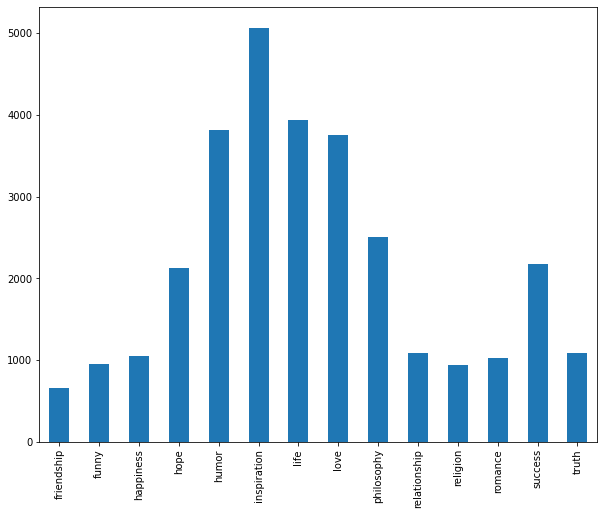

In [24]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_labels.sum(axis=0).plot.bar()

In [25]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [26]:
df.columns

Index(['Quote', 'friendship', 'funny', 'happiness', 'hope', 'humor',
       'inspiration', 'life', 'love', 'philosophy', 'relationship', 'religion',
       'romance', 'success', 'truth'],
      dtype='object')

In [27]:
X = []
sentences = list(df["Quote"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = df[['friendship', 'funny', 'happiness', 'hope', 'humor',
       'inspiration', 'life', 'love', 'philosophy', 'relationship', 'religion',
       'romance', 'success', 'truth']]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [29]:
y1_train = y_train[["friendship"]].values
y1_test =  y_test[["friendship"]].values

# Second output
y2_train = y_train[["funny"]].values
y2_test =  y_test[["funny"]].values

# Third output
y3_train = y_train[["happiness"]].values
y3_test =  y_test[["happiness"]].values

# Fourth output
y4_train = y_train[["hope"]].values
y4_test =  y_test[["hope"]].values

# Fifth output
y5_train = y_train[["humor"]].values
y5_test =  y_test[["humor"]].values

# Sixth output
y6_train = y_train[["inspiration"]].values
y6_test =  y_test[["inspiration"]].values

# Seventh output
y7_train = y_train[["life"]].values
y7_test =  y_test[["life"]].values

# Eight output
y8_train = y_train[["love"]].values
y8_test =  y_test[["love"]].values

# Nine output
y9_train = y_train[["philosophy"]].values
y9_test =  y_test[["philosophy"]].values

# Ten output
y10_train = y_train[["relationship"]].values
y10test =  y_test[["relationship"]].values

# Eleven output
y11_train = y_train[["religion"]].values
y11_test =  y_test[["religion"]].values

# Twelve output
y12_train = y_train[["romance"]].values
y12_test =  y_test[["romance"]].values

# Thirteen output
y13_train = y_train[["success"]].values
y13_test =  y_test[["success"]].values

# Fourteen output
y14_train = y_train[["truth"]].values
y14_test =  y_test[["truth"]].values

In [30]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [33]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/Colab Notebooks/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [35]:
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output7 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output8 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output9 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output10 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output11 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output12 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output13 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output14 = Dense(1, activation='sigmoid')(LSTM_Layer1)


model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6,output7, output8, output9, output10, output11, output12,output13, output14])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [36]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     2385600     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 128)          117248      embedding_2[0][0]                
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 1)            129         lstm_2[0][0]                     
____________________________________________________________________________________________

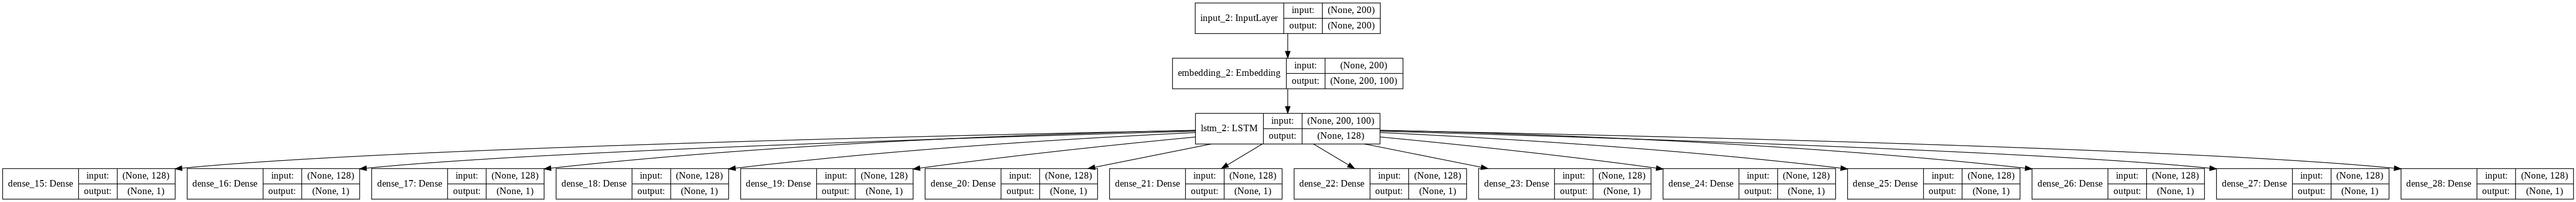

In [37]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [42]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train,y7_train, y8_train, y9_train, y10_train, y11_train, y12_train,y13_train, y14_train], batch_size=8192, epochs=100, verbose=1, validation_split=0.2)

Train on 19318 samples, validate on 4830 samples
Epoch 1/100
19318/19318 [==============================] - 85s 4ms/step - loss: 3.7236 - dense_15_loss: 0.1662 - dense_16_loss: 0.1468 - dense_17_loss: 0.1506 - dense_18_loss: 0.2618 - dense_19_loss: 0.4221 - dense_20_loss: 0.4546 - dense_21_loss: 0.3868 - dense_22_loss: 0.4296 - dense_23_loss: 0.3427 - dense_24_loss: 0.1573 - dense_25_loss: 0.1505 - dense_26_loss: 0.2017 - dense_27_loss: 0.2813 - dense_28_loss: 0.1551 - dense_15_acc: 0.9775 - dense_16_acc: 0.9676 - dense_17_acc: 0.9650 - dense_18_acc: 0.9287 - dense_19_acc: 0.8723 - dense_20_acc: 0.8356 - dense_21_acc: 0.8684 - dense_22_acc: 0.8748 - dense_23_acc: 0.9170 - dense_24_acc: 0.9643 - dense_25_acc: 0.9677 - dense_26_acc: 0.9637 - dense_27_acc: 0.9290 - dense_28_acc: 0.9641 - val_loss: 3.6374 - val_dense_15_loss: 0.1417 - val_dense_16_loss: 0.1599 - val_dense_17_loss: 0.1596 - val_dense_18_loss: 0.2583 - val_dense_19_loss: 0.3969 - val_dense_20_loss: 0.4683 - val_dense_21_loss

In [41]:
score = model.evaluate(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train,y7_train, y8_train, y9_train, y10_train, y11_train, y12_train,y13_train, y14_train], verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

24148/24148 [==============================] - 44s 2ms/step
Test Score: 3.7678517521622363
Test Accuracy: 0.18233203887939453


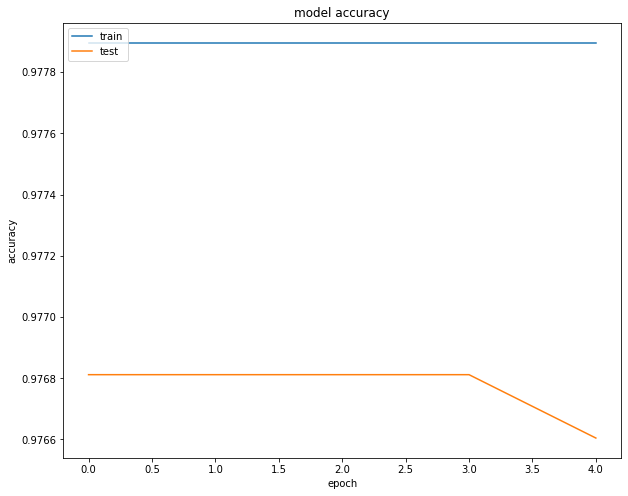

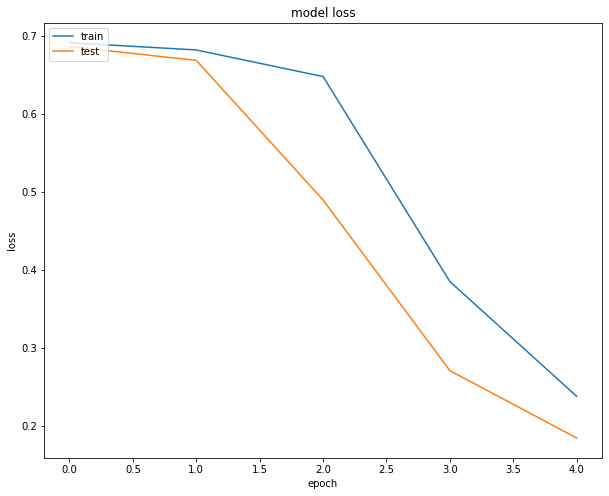

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['dense_15_acc'])
plt.plot(history.history['val_dense_15_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_15_loss'])
plt.plot(history.history['val_dense_15_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()